# Задача

Сетевой супермаркет внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:  
 - Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
 - Контролировать добросовестность кассиров при продаже алкоголя.


Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

# Исследовательский анализ данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np

Found 7591 validated image filenames.


array([[<AxesSubplot:title={'center':'real_age'}>]], dtype=object)

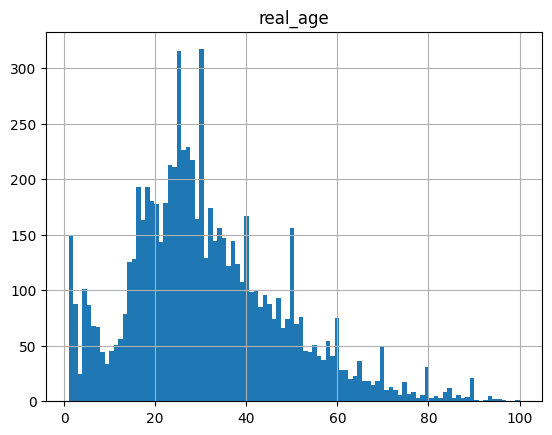

In [2]:
labels = pd.read_csv('labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='final_files/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

labels.hist(bins=100)

<AxesSubplot:>

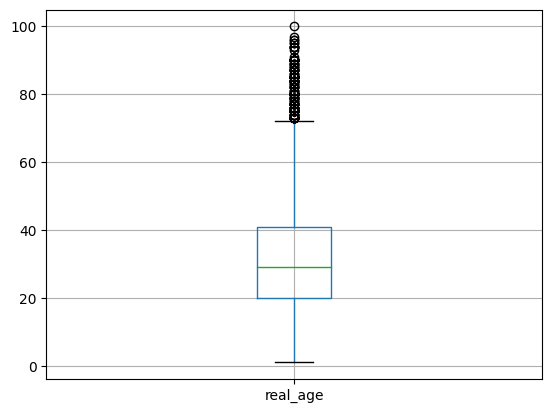

In [3]:
labels.boxplot()

In [4]:
labels['file_name'].duplicated().sum()

0

In [5]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [6]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


Выбросы в "boxplot" возрасте присутствуют, но они не настолько большие, чтобы их надо было исключать  
Пропусков и дубликатов нет  
Распределение возрастов ассиметрично и скошено вправо, поэтому медиана возраста меньше среднего значения

In [7]:
features, target = next(train_gen_flow)

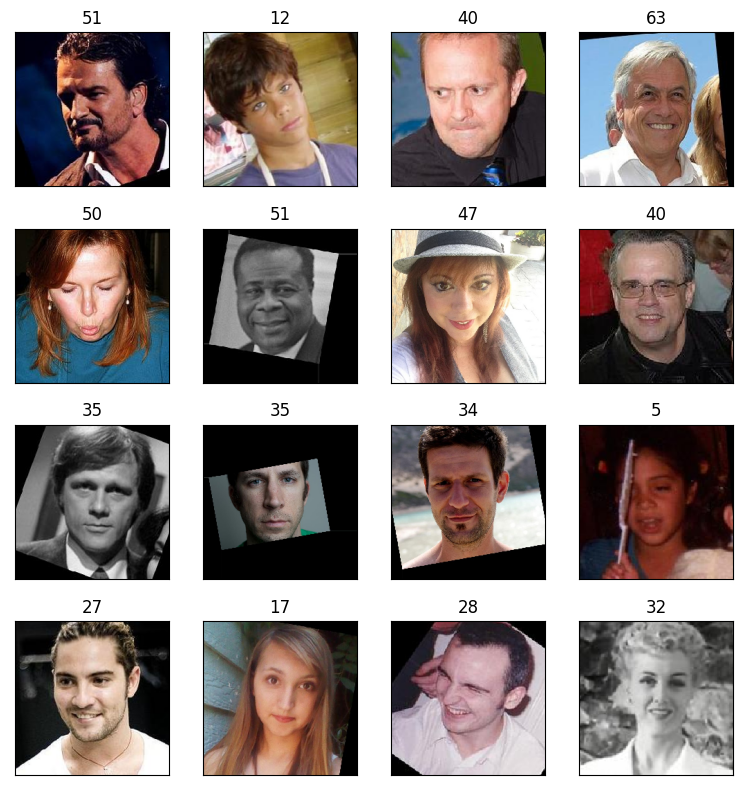

In [8]:
features, target = next(train_gen_flow)
fig = plt.figure(figsize=(8,8))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.title(f'{target[i]}')
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

Фотографии в анфас, иногда находятся в рамке, бывают повернуты, бывают чероно-белыми и цветными

# Создание функций для обработки фотографий

Функция создающая тренировочную часть данных с добавлением горизонтальных отражений картинок для увеличения тренировочных данных в 2 раза

In [9]:
def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(horizontal_flip=True,
    validation_split=0.25,
    rescale=1./255)
 
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path+'final_files/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345) 
 
    return train_gen_flow

Функция создающая тестовую часть данных

In [10]:
def load_test(path):
    validation_datagen = ImageDataGenerator(
    validation_split=0.25,
    rescale=1./255)
 
    valid_gen_flow= validation_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path+'final_files/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345) 
 
    return valid_gen_flow

Функция создающая модель

In [11]:
def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet',
                        include_top=False)
 
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
 
    optimizer = Adam(learning_rate=0.0003)
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])
 
    return model

Функция для тренировки и теста модели

In [12]:
def train_model(model, train_gen_flow, valid_gen_flow, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):
 
    if steps_per_epoch is None:
        steps_per_epoch = len(train_gen_flow)
    if validation_steps is None:
        validation_steps = len(valid_gen_flow)
 
    model.fit(train_gen_flow,
              validation_data=valid_gen_flow,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
 
    return model

# Обучение модели

Создаем тренировочную и тестовую выборки

In [13]:
path = ''
train_data = load_train(path)
test_data = load_test(path)

Found 5694 validated image filenames.
Found 1897 validated image filenames.


In [14]:
model = create_model(input_shape=(224, 224, 3))

In [17]:
train_model(model, train_data, test_data)

```

178/178 - 109s - loss: 251.6145 - mae: 11.4125 - val_loss: 637.9140 - val_mae: 20.2850
Epoch 2/20
178/178 - 39s - loss: 61.7572 - mae: 5.9401 - val_loss: 608.8869 - val_mae: 19.5999
Epoch 3/20
178/178 - 38s - loss: 31.0627 - mae: 4.2809 - val_loss: 212.1844 - val_mae: 10.7452
Epoch 4/20
178/178 - 38s - loss: 19.3834 - mae: 3.3812 - val_loss: 108.6034 - val_mae: 7.8539
Epoch 5/20
178/178 - 38s - loss: 14.8282 - mae: 2.9645 - val_loss: 90.8227 - val_mae: 7.1535
Epoch 6/20
178/178 - 38s - loss: 11.5018 - mae: 2.5951 - val_loss: 74.7036 - val_mae: 6.5883
Epoch 7/20
178/178 - 39s - loss: 9.6763 - mae: 2.3440 - val_loss: 87.6197 - val_mae: 7.0341
Epoch 8/20
178/178 - 39s - loss: 8.9439 - mae: 2.2867 - val_loss: 66.0434 - val_mae: 6.1521
Epoch 9/20
178/178 - 38s - loss: 7.6396 - mae: 2.1038 - val_loss: 66.7214 - val_mae: 6.2085
Epoch 10/20
178/178 - 38s - loss: 7.1816 - mae: 2.0223 - val_loss: 71.1081 - val_mae: 6.2623
Epoch 11/20
178/178 - 38s - loss: 6.5868 - mae: 1.9473 - val_loss: 74.5656 - val_mae: 6.4212
Epoch 12/20
178/178 - 38s - loss: 6.3179 - mae: 1.9166 - val_loss: 65.3655 - val_mae: 6.0555
Epoch 13/20
178/178 - 38s - loss: 6.0668 - mae: 1.8638 - val_loss: 63.3481 - val_mae: 6.0532
Epoch 14/20
178/178 - 38s - loss: 5.7241 - mae: 1.7868 - val_loss: 63.6816 - val_mae: 6.0798
Epoch 15/20
178/178 - 39s - loss: 5.2133 - mae: 1.7124 - val_loss: 68.2815 - val_mae: 6.2957
Epoch 16/20
178/178 - 38s - loss: 5.3108 - mae: 1.7498 - val_loss: 69.9888 - val_mae: 6.3478
Epoch 17/20
178/178 - 38s - loss: 5.2060 - mae: 1.7352 - val_loss: 67.9964 - val_mae: 6.2881
Epoch 18/20
178/178 - 38s - loss: 5.1874 - mae: 1.7041 - val_loss: 62.5474 - val_mae: 5.9730
Epoch 19/20
178/178 - 39s - loss: 4.9265 - mae: 1.6782 - val_loss: 68.1521 - val_mae: 6.1596
Epoch 20/20
178/178 - 39s - loss: 5.5960 - mae: 1.8034 - val_loss: 65.2592 - val_mae: 6.1876
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 10s - loss: 65.2592 - mae: 6.1876
Test MAE: 6.1876
```

# Анализ обученной модели

Была ипользована модель ResNet50 на 20 эпохах, для увеличении тренировочной выборки в 2 раза были отзеркалены все фотографии, достигнута **MAE** 6.19, наша модель ошибается в среднем на 6 лет в большую или меньшую сторону.